# Metriq Data: Standalone Analysis Tutorial

> **Note:** This notebook is a template and starting point for users to perform their own analyses. The results shown here are for demonstration purposes only, illustrating the analysis pipeline and available data structure. As more benchmark data is continuously uploaded to the metriq-data repository, users should adapt this notebook for their specific research questions and analysis needs.

## Overview

The metriq-data repository contains benchmark results from various quantum computing devices across multiple providers (IBM, AWS, Quantinuum, etc.). This tutorial will show you how to:

1. Load and explore aggregated benchmark data
2. Compare performance of devices from the same provider
3. Analyze multiple metrics across different devices
4. Investigate the relationship between device scale (qubit count) and performance
5. Create clear, informative visualizations

## Dataset Structure

The data is organized by:
- **Version** (e.g., v0.4, v0.5, v0.6) - we use v0.4 which has the most complete aggregated results
- **Provider** (e.g., IBM, AWS, Quantinuum)
- **Device** (e.g., ibm_boston, ibm_torino)
- **Benchmark types** (e.g., BSEQ, QML Kernel, Linear Ramp QAOA, WIT)

## 1. Setup

First, let's import the necessary libraries for data analysis and visualization.

In [15]:
# Import required libraries
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Set up plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10


## 2. Explore Available Datasets

Let's explore the structure of the metriq-gym data directory and see what's available.

In [2]:
# Define the base path for metriq-gym data
base_path = Path('metriq-gym/v0.4')

# Explore available providers and devices
providers = {}
for provider_path in base_path.iterdir():
    if provider_path.is_dir():
        provider_name = provider_path.name
        devices = []
        
        # Check for results.json
        results_file = provider_path / 'results.json'
        if results_file.exists():
            # Look for device-specific directories
            for device_path in provider_path.iterdir():
                if device_path.is_dir():
                    devices.append(device_path.name)
        
        if devices or results_file.exists():
            providers[provider_name] = {
                'path': provider_path,
                'devices': devices,
                'has_aggregated': results_file.exists()
            }

# Display what we found
print("Available Providers and Devices:\n")
for provider, info in sorted(providers.items()):
    print(f"{provider.upper()}:")
    has_agg = "Yes" if info['has_aggregated'] else "No"
    print(f"  Aggregated data: {has_agg}")
    if info['devices']:
        print(f"  Devices: {', '.join(sorted(info['devices']))}")
    print()

Available Providers and Devices:

AWS:
  Aggregated data: Yes
  Devices: arn_aws_braket_eu-north-1_device_qpu_iqm_garnet

IBM:
  Aggregated data: Yes
  Devices: ibm_boston, ibm_fez, ibm_kingston, ibm_marrakesh, ibm_pittsburgh, ibm_torino

LOCAL:
  Aggregated data: Yes

ORIGIN:
  Aggregated data: Yes
  Devices: 72

QUANTINUUM:
  Aggregated data: Yes



## 3. Load Device Benchmark Data

Now let's load the aggregated results from the IBM provider. The aggregated `results.json` files contain benchmark results across all devices for that provider.

In [3]:
def load_aggregated_results(provider_name):
    """Load aggregated results for a given provider."""
    results_file = base_path / provider_name / 'results.json'
    
    with open(results_file, 'r') as f:
        data = json.load(f)
    
    # Convert to DataFrame with flattened structure
    records = []
    for entry in data:
        record = {
            'timestamp': entry.get('timestamp'),
            'job_type': entry.get('job_type'),
            'device': entry.get('platform', {}).get('device'),
            'provider': entry.get('platform', {}).get('provider'),
            'num_qubits': entry.get('platform', {}).get('device_metadata', {}).get('num_qubits'),
            'simulator': entry.get('platform', {}).get('device_metadata', {}).get('simulator', False),
            'runtime_seconds': entry.get('runtime_seconds'),
        }
        
        # Extract results values
        results = entry.get('results', {})
        if 'values' in results:
            for key, value in results['values'].items():
                record[f'value_{key}'] = value
        
        # Extract score if present
        if 'score' in results:
            if isinstance(results['score'], dict):
                record['score'] = results['score'].get('value')
            else:
                record['score'] = results['score']
        
        # Extract parameters
        params = entry.get('params', {})
        for key, value in params.items():
            if key not in ['benchmark_name']:  # benchmark_name is already in job_type
                record[f'param_{key}'] = value
        
        records.append(record)
    
    df = pd.DataFrame(records)
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    
    # Create a unified performance metric based on benchmark type
    # For benchmarks without a score field, use their primary metric
    df['performance_metric'] = df['score']
    
    # For BSEQ: use largest_connected_size when score is missing
    bseq_mask = (df['job_type'] == 'BSEQ') & df['performance_metric'].isna()
    df.loc[bseq_mask, 'performance_metric'] = df.loc[bseq_mask, 'value_largest_connected_size']
    
    # For WIT: use expectation_value
    wit_mask = (df['job_type'] == 'WIT') & df['performance_metric'].isna()
    df.loc[wit_mask, 'performance_metric'] = df.loc[wit_mask, 'value_expectation_value']
    
    # For QML Kernel: use accuracy_score
    qml_mask = (df['job_type'] == 'QML Kernel') & df['performance_metric'].isna()
    df.loc[qml_mask, 'performance_metric'] = df.loc[qml_mask, 'value_accuracy_score']
    
    return df

# Load IBM data
ibm_df = load_aggregated_results('ibm')

print(f"Loaded {len(ibm_df)} benchmark results from IBM devices")
print(f"\nDevices: {sorted(ibm_df['device'].unique())}")
print(f"Benchmark types: {sorted(ibm_df['job_type'].unique())}")
print(f"\nDataFrame shape: {ibm_df.shape}")
print("\nFirst few rows:")
ibm_df.head()

Loaded 23 benchmark results from IBM devices

Devices: ['ibm_boston', 'ibm_brisbane', 'ibm_fez', 'ibm_kingston', 'ibm_marrakesh', 'ibm_pittsburgh', 'ibm_torino']
Benchmark types: ['BSEQ', 'QML Kernel', 'WIT']

DataFrame shape: (23, 15)

First few rows:


,timestamp,job_type,device,provider,num_qubits,simulator,runtime_seconds,value_largest_connected_size,value_fraction_connected,score,param_shots,value_expectation_value,param_num_qubits,value_accuracy_score,performance_metric
0,2025-12-09 15:49:16.537087,BSEQ,ibm_boston,ibm,156,False,5.838338,156.0,1.0,156.0,1000,NaN,NaN,NaN,156.000000
1,2025-10-22 15:51:29.253484,WIT,ibm_fez,ibm,156,False,NaN,NaN,NaN,NaN,8192,0.683350,7.0,NaN,0.683350
2,2025-10-22 15:51:29.253484,WIT,ibm_fez,ibm,156,False,NaN,NaN,NaN,NaN,8192,0.683350,7.0,NaN,0.683350
3,2025-10-22 10:17:33.891024,WIT,ibm_brisbane,ibm,127,False,NaN,NaN,NaN,NaN,8192,0.498535,7.0,NaN,0.498535
4,2025-10-19 14:10:17.439739,BSEQ,ibm_torino,ibm,133,False,NaN,113.0,NaN,NaN,1000,NaN,NaN,NaN,113.000000


### Data Quality Check

Let's examine the data quality and understand which benchmarks have scores vs other metrics.

In [4]:
# Check data quality
print("DATA QUALITY ANALYSIS")
print("=" * 80)

# Check for scores
print(f"\nTotal records: {len(ibm_df)}")
print(f"Records with 'score' field: {ibm_df['score'].notna().sum()}")
print(f"Records with performance_metric: {ibm_df['performance_metric'].notna().sum()}")
print(f"Records missing data: {ibm_df['performance_metric'].isna().sum()}")

# Show which benchmarks have metrics
print("\nMetric availability by benchmark type:")
for benchmark in ibm_df['job_type'].unique():
    subset = ibm_df[ibm_df['job_type'] == benchmark]
    has_metric = subset['performance_metric'].notna().sum()
    print(f"  {benchmark}: {has_metric}/{len(subset)} records have performance metrics")

# Show metric availability by device
print("\nMetric availability by device:")
metric_by_device = ibm_df.groupby('device').agg({
    'performance_metric': lambda x: f"{x.notna().sum()}/{len(x)}"
})
print(metric_by_device)

# Show what metrics each benchmark uses
print("\nMetric mapping by benchmark type:")
for benchmark in ibm_df['job_type'].unique():
    sample = ibm_df[ibm_df['job_type'] == benchmark].iloc[0]
    print(f"\n{benchmark}:")
    if pd.notna(sample['score']):
        print(f"  Uses 'score' field: {sample['score']}")
    elif pd.notna(sample['value_expectation_value']):
        print(f"  Uses 'value_expectation_value': {sample['value_expectation_value']}")
    elif pd.notna(sample['value_accuracy_score']):
        print(f"  Uses 'value_accuracy_score': {sample['value_accuracy_score']}")
    print(f"  Unified performance_metric: {sample['performance_metric']}")

DATA QUALITY ANALYSIS

Total records: 23
Records with 'score' field: 1
Records with performance_metric: 22
Records missing data: 1

Metric availability by benchmark type:
  BSEQ: 6/6 records have performance metrics
  WIT: 4/5 records have performance metrics
  QML Kernel: 12/12 records have performance metrics

Metric availability by device:
               performance_metric
device                           
ibm_boston                    1/1
ibm_brisbane                  3/3
ibm_fez                       5/6
ibm_kingston                  3/3
ibm_marrakesh                 3/3
ibm_pittsburgh                3/3
ibm_torino                    4/4

Metric mapping by benchmark type:

BSEQ:
  Uses 'score' field: 156.0
  Unified performance_metric: 156.0

WIT:
  Uses 'value_expectation_value': 0.683349609375
  Unified performance_metric: 0.683349609375

QML Kernel:
  Uses 'value_accuracy_score': 0.285
  Unified performance_metric: 0.285


### Understanding the Data

**Important Note on Metrics:**

Different benchmark types use different performance metrics:
- **BSEQ**: Uses a `score` field (typically > 100, representing connected component size)
- **WIT**: Uses `value_expectation_value` (range 0-1)
- **QML Kernel**: Uses `value_accuracy_score` (range 0-1)

To enable comprehensive analysis across all benchmarks, we created a unified `performance_metric` field that automatically selects the appropriate metric for each benchmark type. This allows us to compare devices even when they're tested on different benchmark suites.

## 4. Compare Two Devices from Same Provider: Single Metric

Let's compare two IBM devices on the BSEQ (Benchmark for Scalable Error Quantification) benchmark. We'll look at the "largest_connected_size" metric, which measures the largest connected component of qubits that can be reliably operated.

BSEQ benchmark results per device:
device
ibm_boston        1
ibm_torino        1
ibm_marrakesh     1
ibm_fez           1
ibm_kingston      1
ibm_pittsburgh    1
Name: count, dtype: int64



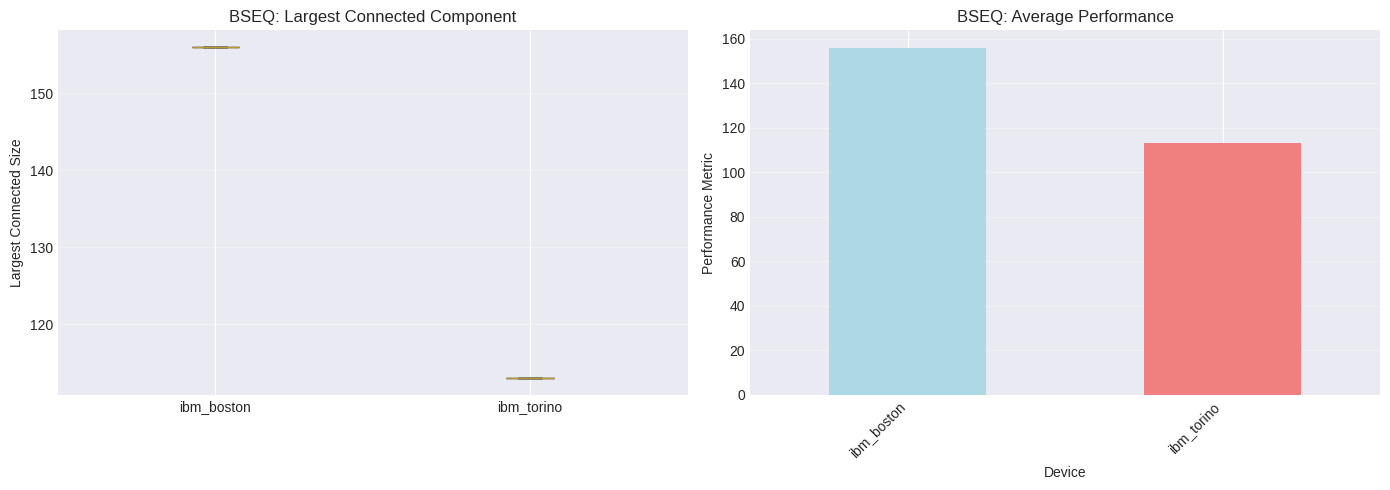


Statistical Comparison: ibm_boston vs ibm_torino

ibm_boston:
  Number of runs: 1
  Average performance: 156.00 ± nan
  Average largest connected size: 156.00
  Device qubits: 156

ibm_torino:
  Number of runs: 1
  Average performance: 113.00 ± nan
  Average largest connected size: 113.00
  Device qubits: 133


In [5]:
# Filter for BSEQ benchmark results
bseq_df = ibm_df[ibm_df['job_type'] == 'BSEQ'].copy()

# Select two devices for comparison (devices with most data)
device_counts = bseq_df['device'].value_counts()
print("BSEQ benchmark results per device:")
print(device_counts)
print()

# Compare devices
devices_to_compare = device_counts.head(2).index.tolist()
if len(devices_to_compare) >= 2:
    device1, device2 = devices_to_compare[0], devices_to_compare[1]
    
    comparison_df = bseq_df[bseq_df['device'].isin([device1, device2])]
    
    # Create comparison plot
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Plot 1: Largest connected size comparison
    ax1 = axes[0]
    data_to_plot = []
    labels = []
    for device in [device1, device2]:
        device_data = comparison_df[comparison_df['device'] == device]['value_largest_connected_size'].dropna()
        if len(device_data) > 0:
            data_to_plot.append(device_data)
            labels.append(device)
    
    if data_to_plot:
        bp = ax1.boxplot(data_to_plot, labels=labels, patch_artist=True)
        for patch, color in zip(bp['boxes'], ['lightblue', 'lightcoral']):
            patch.set_facecolor(color)
        ax1.set_ylabel('Largest Connected Size')
        ax1.set_title('BSEQ: Largest Connected Component')
        ax1.grid(axis='y', alpha=0.3)
    
    # Plot 2: Performance metric comparison
    ax2 = axes[1]
    score_comparison = comparison_df.groupby('device')['performance_metric'].agg(['mean', 'std', 'count'])
    score_comparison = score_comparison[score_comparison['count'] > 0]
    if not score_comparison.empty:
        score_comparison.plot(kind='bar', y='mean', yerr='std', ax=ax2, 
                              color=['lightblue', 'lightcoral'], legend=False)
        ax2.set_ylabel('Performance Metric')
        ax2.set_title('BSEQ: Average Performance')
        ax2.set_xlabel('Device')
        ax2.grid(axis='y', alpha=0.3)
        plt.xticks(rotation=45, ha='right')
    
    plt.tight_layout()
    plt.show()
    
    # Print statistics
    print(f"\nStatistical Comparison: {device1} vs {device2}")
    print("="*60)
    for device in [device1, device2]:
        device_perf = comparison_df[comparison_df['device'] == device]['performance_metric'].dropna()
        device_lcs = comparison_df[comparison_df['device'] == device]['value_largest_connected_size'].dropna()
        print(f"\n{device}:")
        print(f"  Number of runs: {len(device_perf)}")
        if len(device_perf) > 0:
            print(f"  Average performance: {device_perf.mean():.2f} ± {device_perf.std():.2f}")
            print(f"  Average largest connected size: {device_lcs.mean():.2f}")
        else:
            print(f"  No valid performance data available")
        print(f"  Device qubits: {comparison_df[comparison_df['device'] == device]['num_qubits'].iloc[0]}")
else:
    print("Not enough devices with BSEQ data for comparison.")

## 5. Analyze Benchmark Activity Across Devices

Now let's examine which IBM devices have been tested with different benchmark types to understand the coverage and activity.

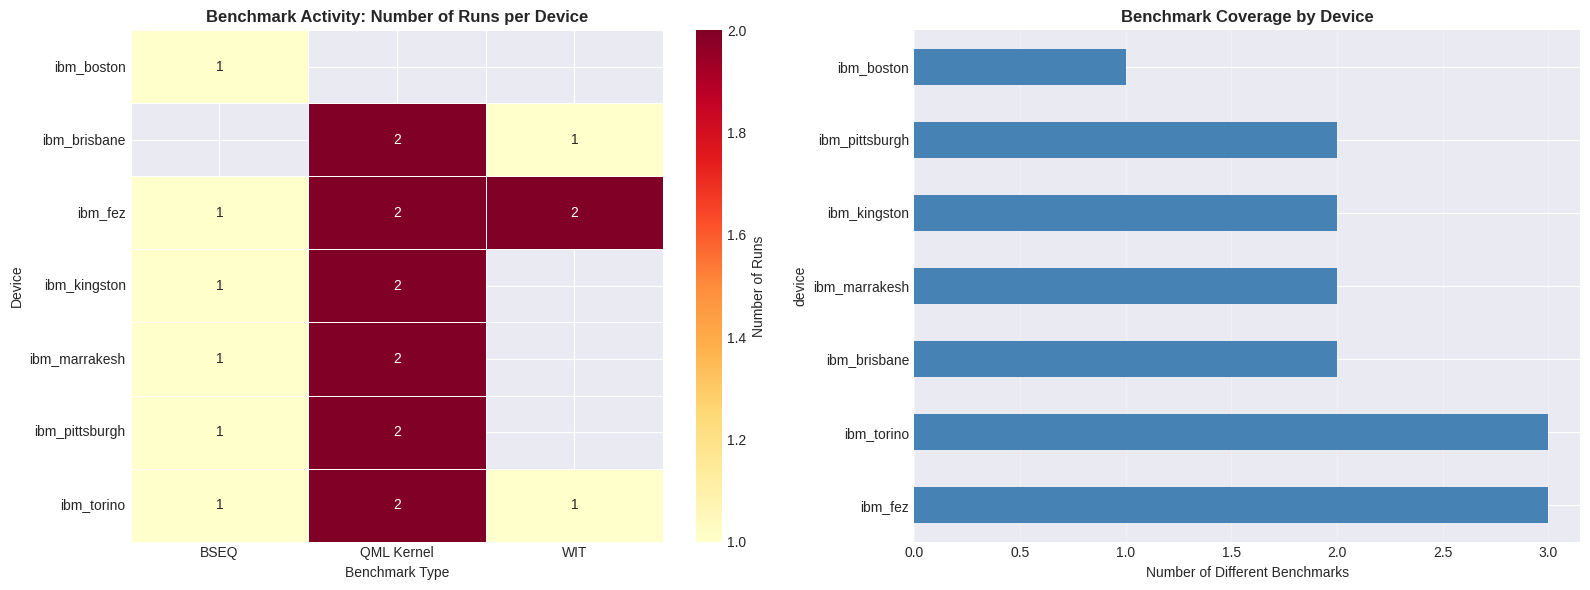


Benchmark Activity Summary

Total devices analyzed: 7
Total benchmark types: 3

Benchmark types available: BSEQ, QML Kernel, WIT

Note: The heatmap shows the number of benchmark runs, not performance scores.
Direct comparison of raw performance values across different benchmark types
is not meaningful as they use different scales and metrics.


In [6]:
# Create a summary of average performance per device and benchmark type
device_benchmark_summary = ibm_df.groupby(['device', 'job_type'])['performance_metric'].agg(['mean', 'count']).reset_index()
device_benchmark_summary = device_benchmark_summary[device_benchmark_summary['count'] >= 1]  # Filter for significance

# Pivot for heatmap - show number of runs instead of comparing raw values
# (Note: different benchmarks have different scales and metrics, so direct comparison isn't meaningful)
heatmap_data = device_benchmark_summary.pivot(index='device', columns='job_type', values='count')

# Create visualization
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Heatmap showing number of benchmark runs per device
ax1 = axes[0]
if not heatmap_data.empty:
    sns.heatmap(heatmap_data, annot=True, fmt='.0f', cmap='YlOrRd', 
                cbar_kws={'label': 'Number of Runs'}, ax=ax1, linewidths=0.5)
    ax1.set_title('Benchmark Activity: Number of Runs per Device', fontsize=12, fontweight='bold')
    ax1.set_xlabel('Benchmark Type')
    ax1.set_ylabel('Device')
else:
    ax1.text(0.5, 0.5, 'Insufficient data for heatmap', ha='center', va='center')

# Bar chart showing benchmark coverage per device
ax2 = axes[1]
coverage = ibm_df.groupby('device')['job_type'].nunique().sort_values(ascending=False)
coverage.plot(kind='barh', ax=ax2, color='steelblue')
ax2.set_xlabel('Number of Different Benchmarks')
ax2.set_title('Benchmark Coverage by Device', fontsize=12, fontweight='bold')
ax2.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

# Print summary
print("\nBenchmark Activity Summary")
print("="*60)
print(f"\nTotal devices analyzed: {len(heatmap_data)}")
print(f"Total benchmark types: {len(heatmap_data.columns)}")
print(f"\nBenchmark types available: {', '.join(heatmap_data.columns)}")
print("\nNote: The heatmap shows the number of benchmark runs, not performance scores.")
print("Direct comparison of raw performance values across different benchmark types")
print("is not meaningful as they use different scales and metrics.")

## 6. Correlation Analysis: Scale vs Quality

One of the most interesting questions in quantum computing is: **Does having more qubits lead to better performance?**

Let's investigate the relationship between device scale (number of qubits) and benchmark performance.

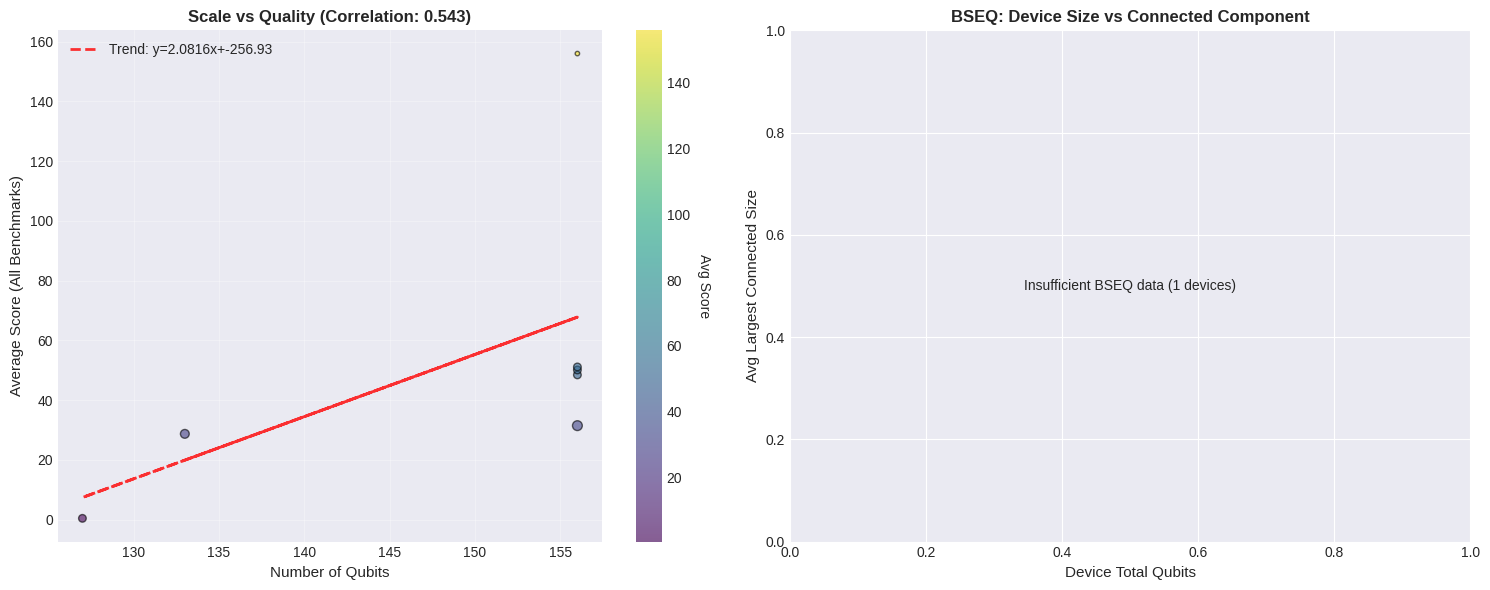


Scale vs Quality Analysis

Overall Correlation (All Benchmarks):
  Qubits vs Score: 0.543
  ⚠️  Note: This averages heterogeneous metrics (BSEQ ~100-156, QML/WIT 0-1)
  Interpretation: Moderate correlation - some relationship between size and performance

BSEQ Benchmark Specific:
  Insufficient data for correlation analysis (1 devices with valid data)

Note: Bubble size represents number of benchmark runs for each device.


In [14]:
# Calculate average performance metrics per device
device_stats = ibm_df.groupby('device').agg({
    'num_qubits': 'first',
    'performance_metric': ['mean', 'std', 'count']
}).reset_index()

device_stats.columns = ['device', 'num_qubits', 'avg_score', 'std_score', 'num_results']
# Filter out devices with no valid performance metrics
device_stats = device_stats[(device_stats['num_results'] >= 1) & (device_stats['avg_score'].notna())]

# Create scatter plots
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Plot 1: Qubits vs Average Score (all benchmarks)
ax1 = axes[0]
scatter = ax1.scatter(device_stats['num_qubits'], device_stats['avg_score'], 
                      s=device_stats['num_results']*10, alpha=0.6, c=device_stats['avg_score'],
                      cmap='viridis', edgecolors='black', linewidth=1)

# Add trend line
if len(device_stats) > 1:
    z = np.polyfit(device_stats['num_qubits'], device_stats['avg_score'], 1)
    p = np.poly1d(z)
    ax1.plot(device_stats['num_qubits'], p(device_stats['num_qubits']), 
             "r--", alpha=0.8, linewidth=2, label=f'Trend: y={z[0]:.4f}x+{z[1]:.2f}')

# Calculate correlation
correlation = device_stats['num_qubits'].corr(device_stats['avg_score'])
ax1.set_xlabel('Number of Qubits', fontsize=11)
ax1.set_ylabel('Average Score (All Benchmarks)', fontsize=11)
ax1.set_title(f'Scale vs Quality (Correlation: {correlation:.3f})', fontsize=12, fontweight='bold')
ax1.grid(alpha=0.3)
ax1.legend()

# Add colorbar
cbar = plt.colorbar(scatter, ax=ax1)
cbar.set_label('Avg Score', rotation=270, labelpad=15)

# Plot 2: Focus on BSEQ benchmark (which uses largest_connected_size)
ax2 = axes[1]
bseq_stats = ibm_df[ibm_df['job_type'] == 'BSEQ'].groupby('device').agg({
    'num_qubits': 'first',
    'value_largest_connected_size': 'mean',
    'score': 'count'
}).reset_index()
bseq_stats.columns = ['device', 'num_qubits', 'avg_connected_size', 'count']
# Filter out devices with no valid connected size data
bseq_stats = bseq_stats[(bseq_stats['count'] >= 1) & (bseq_stats['avg_connected_size'].notna())]

if not bseq_stats.empty and len(bseq_stats) >= 2:
    scatter2 = ax2.scatter(bseq_stats['num_qubits'], bseq_stats['avg_connected_size'],
                           s=bseq_stats['count']*20, alpha=0.6, c=bseq_stats['avg_connected_size'],
                           cmap='plasma', edgecolors='black', linewidth=1)
    
    # Add trend line
    if len(bseq_stats) > 1:
        z2 = np.polyfit(bseq_stats['num_qubits'], bseq_stats['avg_connected_size'], 1)
        p2 = np.poly1d(z2)
        ax2.plot(bseq_stats['num_qubits'], p2(bseq_stats['num_qubits']), 
                 "r--", alpha=0.8, linewidth=2, label=f'Trend: y={z2[0]:.4f}x+{z2[1]:.2f}')
    
    correlation2 = bseq_stats['num_qubits'].corr(bseq_stats['avg_connected_size'])
    ax2.set_xlabel('Device Total Qubits', fontsize=11)
    ax2.set_ylabel('Avg Largest Connected Size', fontsize=11)
    ax2.set_title(f'BSEQ: Device Size vs Connected Component (Corr: {correlation2:.3f})', 
                  fontsize=12, fontweight='bold')
    ax2.grid(alpha=0.3)
    ax2.legend()
    
    cbar2 = plt.colorbar(scatter2, ax=ax2)
    cbar2.set_label('Connected Size', rotation=270, labelpad=15)
else:
    ax2.text(0.5, 0.5, f'Insufficient BSEQ data ({len(bseq_stats)} devices)', 
             ha='center', va='center', transform=ax2.transAxes)
    ax2.set_xlabel('Device Total Qubits', fontsize=11)
    ax2.set_ylabel('Avg Largest Connected Size', fontsize=11)
    ax2.set_title('BSEQ: Device Size vs Connected Component', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

# Print analysis
print("\nScale vs Quality Analysis")
print("="*60)
print(f"\nOverall Correlation (All Benchmarks):")
print(f"  Qubits vs Score: {correlation:.3f}")
print(f"  ⚠️  Note: This averages heterogeneous metrics (BSEQ ~100-156, QML/WIT 0-1)")
print(f"  Interpretation: ", end="")
if abs(correlation) < 0.3:
    print("Weak correlation - more qubits doesn't necessarily mean better scores")
elif abs(correlation) < 0.7:
    print("Moderate correlation - some relationship between size and performance")
else:
    print("Strong correlation - device size significantly affects performance")

if not bseq_stats.empty and len(bseq_stats) >= 2:
    print(f"\nBSEQ Benchmark Specific:")
    print(f"  Device Qubits vs Connected Component: {correlation2:.3f}")
    print(f"  This measures how many qubits can work together reliably")
else:
    print(f"\nBSEQ Benchmark Specific:")
    print(f"  Insufficient data for correlation analysis ({len(bseq_stats)} devices with valid data)")

print(f"\nNote: Bubble size represents number of benchmark runs for each device.")

## 7. Visualize Device Performance Over Time

Let's analyze how device performance has evolved over time by examining the temporal patterns in the benchmark results.

**Note:** When analyzing trends, we separate analysis by benchmark type to avoid comparing incompatible metrics (e.g., BSEQ scores ~100-156 vs QML/WIT scores 0-1).

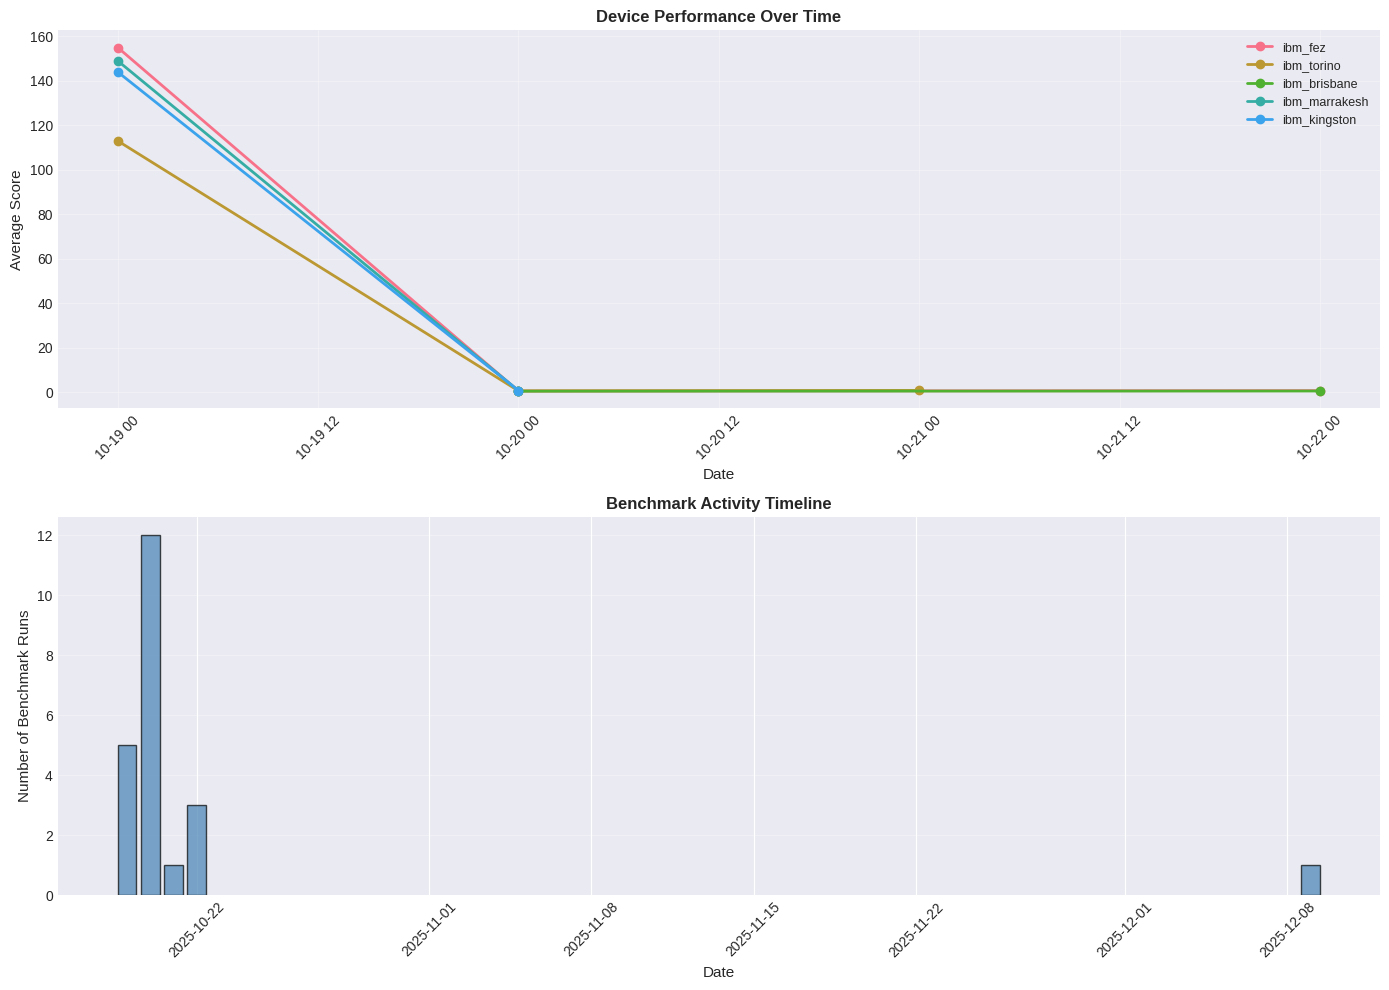


Temporal Analysis
Date range: 2025-10-19 to 2025-12-09
Total days with activity: 5
Average benchmarks per active day: 4.4

Performance Trends (by benchmark type):

  ibm_fez:
    WIT: +0.0% change (n=2 runs)
    BSEQ: Only 1 run, no trend available
    QML Kernel: -32.9% change (n=2 runs)

  ibm_torino:
    BSEQ: Only 1 run, no trend available
    QML Kernel: -32.1% change (n=2 runs)
    WIT: Only 1 run, no trend available

  ibm_brisbane:
    WIT: Only 1 run, no trend available
    QML Kernel: -49.1% change (n=2 runs)


In [13]:
# Prepare temporal data
temporal_df = ibm_df[ibm_df['performance_metric'].notna()].copy()
temporal_df['date'] = temporal_df['timestamp'].dt.date

# Get devices with sufficient temporal data
device_counts_temporal = temporal_df.groupby('device')['date'].nunique()
devices_with_temporal = device_counts_temporal[device_counts_temporal >= 3].index.tolist()

if len(devices_with_temporal) > 0:
    fig, axes = plt.subplots(2, 1, figsize=(14, 10))
    
    # Plot 1: Time series of scores for top devices
    ax1 = axes[0]
    
    # Select top 3-5 devices by number of results
    top_devices = temporal_df['device'].value_counts().head(5).index.tolist()
    
    for device in top_devices[:5]:
        device_data = temporal_df[temporal_df['device'] == device].sort_values('timestamp')
        if len(device_data) > 0:
            # Group by date and calculate daily average
            daily_avg = device_data.groupby('date')['performance_metric'].mean().reset_index()
            ax1.plot(daily_avg['date'], daily_avg['performance_metric'], marker='o', label=device, linewidth=2, markersize=6)
    
    ax1.set_xlabel('Date', fontsize=11)
    ax1.set_ylabel('Average Score', fontsize=11)
    ax1.set_title('Device Performance Over Time', fontsize=12, fontweight='bold')
    ax1.legend(loc='best', fontsize=9)
    ax1.grid(alpha=0.3)
    ax1.tick_params(axis='x', rotation=45)
    
    # Plot 2: Benchmark activity timeline
    ax2 = axes[1]
    
    # Count number of benchmarks per day
    activity = temporal_df.groupby('date').size().reset_index()
    activity.columns = ['date', 'count']
    
    ax2.bar(activity['date'], activity['count'], alpha=0.7, color='steelblue', edgecolor='black')
    ax2.set_xlabel('Date', fontsize=11)
    ax2.set_ylabel('Number of Benchmark Runs', fontsize=11)
    ax2.set_title('Benchmark Activity Timeline', fontsize=12, fontweight='bold')
    ax2.grid(axis='y', alpha=0.3)
    ax2.tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    # Print temporal statistics
    print("\nTemporal Analysis")
    print("="*60)
    print(f"Date range: {temporal_df['date'].min()} to {temporal_df['date'].max()}")
    print(f"Total days with activity: {len(activity)}")
    print(f"Average benchmarks per active day: {activity['count'].mean():.1f}")
    
    # Check for trends per benchmark type (to avoid comparing heterogeneous metrics)
    print("\nPerformance Trends (by benchmark type):")
    for device in top_devices[:3]:
        device_data = temporal_df[temporal_df['device'] == device]
        print(f"\n  {device}:")
        
        # Analyze each benchmark type separately
        for benchmark in device_data['job_type'].unique():
            benchmark_data = device_data[device_data['job_type'] == benchmark].sort_values('timestamp')
            if len(benchmark_data) >= 2:
                first_half = benchmark_data.iloc[:len(benchmark_data)//2]['performance_metric'].mean()
                second_half = benchmark_data.iloc[len(benchmark_data)//2:]['performance_metric'].mean()
                change = ((second_half - first_half) / first_half * 100) if first_half > 0 else 0
                print(f"    {benchmark}: {change:+.1f}% change (n={len(benchmark_data)} runs)")
            elif len(benchmark_data) == 1:
                print(f"    {benchmark}: Only 1 run, no trend available")
else:
    print("Not enough temporal data available for time series analysis.")

## 8. Create Comparison Tables

Let's create clear summary tables that can be used for reports or presentations.

In [9]:
# Table 1: Device Overview
# Note: We show raw metric values but do NOT compute averages across heterogeneous metrics
# Different benchmarks use different scales (e.g., BSEQ ~156 vs QML/WIT 0-1)

device_overview = ibm_df.groupby('device').agg({
    'num_qubits': 'first',
    'performance_metric': ['count'],
    'job_type': 'nunique',
    'runtime_seconds': 'mean'
}).round(3)

device_overview.columns = ['Qubits', 'Total Runs', 'Benchmarks', 'Avg Runtime (s)']
device_overview = device_overview.sort_values('Total Runs', ascending=False)

print("Table 1: IBM Device Overview")
print("="*80)
print("Note: Performance metrics are heterogeneous across benchmark types")
print("(e.g., BSEQ scores ~156 vs QML/WIT scores 0-1) and cannot be averaged.")
print("See Table 2 for benchmark-specific performance.")
print()
print(device_overview.to_string())
print()

# Table 2: Benchmark-specific performance (includes all runs, even single-run entries)
benchmark_performance = ibm_df.groupby(['job_type', 'device'])['performance_metric'].agg(['mean', 'count']).reset_index()
benchmark_performance = benchmark_performance.sort_values(['job_type', 'mean'], ascending=[True, False])
benchmark_performance.columns = ['Benchmark', 'Device', 'Avg Score', 'Runs']

print("\nTable 2: Performance by Benchmark Type")
print("="*80)
print("Metrics are benchmark-specific and should only be compared within the same benchmark.")
print()
# Show top performers for each benchmark
for benchmark in benchmark_performance['Benchmark'].unique():
    print(f"\n{benchmark}:")
    subset = benchmark_performance[benchmark_performance['Benchmark'] == benchmark].head(5)
    print(subset[['Device', 'Avg Score', 'Runs']].to_string(index=False))

# Table 3: Runtime efficiency by device
# Note: We show average runtime but avoid computing efficiency metrics that mix heterogeneous scores
runtime_analysis = ibm_df.groupby('device').agg({
    'runtime_seconds': 'mean',
    'num_qubits': 'first',
    'performance_metric': 'count'
}).reset_index()

runtime_analysis = runtime_analysis.sort_values('runtime_seconds', ascending=True)
runtime_analysis = runtime_analysis.round(4)
runtime_analysis.columns = ['Device', 'Avg Runtime (s)', 'Qubits', 'Total Runs']

print("\n\nTable 3: Runtime Analysis")
print("="*80)
print(runtime_analysis[['Device', 'Qubits', 'Total Runs', 'Avg Runtime (s)']].to_string(index=False))
print("\nNote: Runtime efficiency depends on benchmark type. See Table 2 for performance details.")

Table 1: IBM Device Overview
Note: Performance metrics are heterogeneous across benchmark types
(e.g., BSEQ scores ~156 vs QML/WIT scores 0-1) and cannot be averaged.
See Table 2 for benchmark-specific performance.

                Qubits  Total Runs  Benchmarks  Avg Runtime (s)
device                                                         
ibm_fez            156           5           3              NaN
ibm_torino         133           4           3              NaN
ibm_brisbane       127           3           2              NaN
ibm_marrakesh      156           3           2              NaN
ibm_kingston       156           3           2              NaN
ibm_pittsburgh     156           3           2              NaN
ibm_boston         156           1           1            5.838


Table 2: Performance by Benchmark Type
Metrics are benchmark-specific and should only be compared within the same benchmark.


BSEQ:
        Device  Avg Score  Runs
    ibm_boston      156.0     1
       ib

## 9. Generate Summary Statistics

Let's compute comprehensive summary statistics to understand the overall landscape of quantum device performance.

COMPREHENSIVE SUMMARY STATISTICS

1. DATASET OVERVIEW
--------------------------------------------------------------------------------
Total benchmark runs: 23
Unique devices: 7
Benchmark types: 3
Date range: 2025-10-09 to 2025-12-09
Total runtime: 0.00 hours

2. DEVICE SCALE STATISTICS
--------------------------------------------------------------------------------
Qubit count range: 127 - 156
Average device size: 148.2 qubits
Median device size: 156.0 qubits

3. PERFORMANCE STATISTICS
--------------------------------------------------------------------------------
Mean score: 39.9388
Median score: 0.6833
Std deviation: 66.2193
Min score: 0.2850
Max score: 156.0000
25th percentile: 0.5633
75th percentile: 84.9530

4. BENCHMARK DISTRIBUTION
--------------------------------------------------------------------------------
QML Kernel                    :   12 runs ( 52.2%)
BSEQ                          :    6 runs ( 26.1%)
WIT                           :    5 runs ( 21.7%)

5. PERFORMANCE

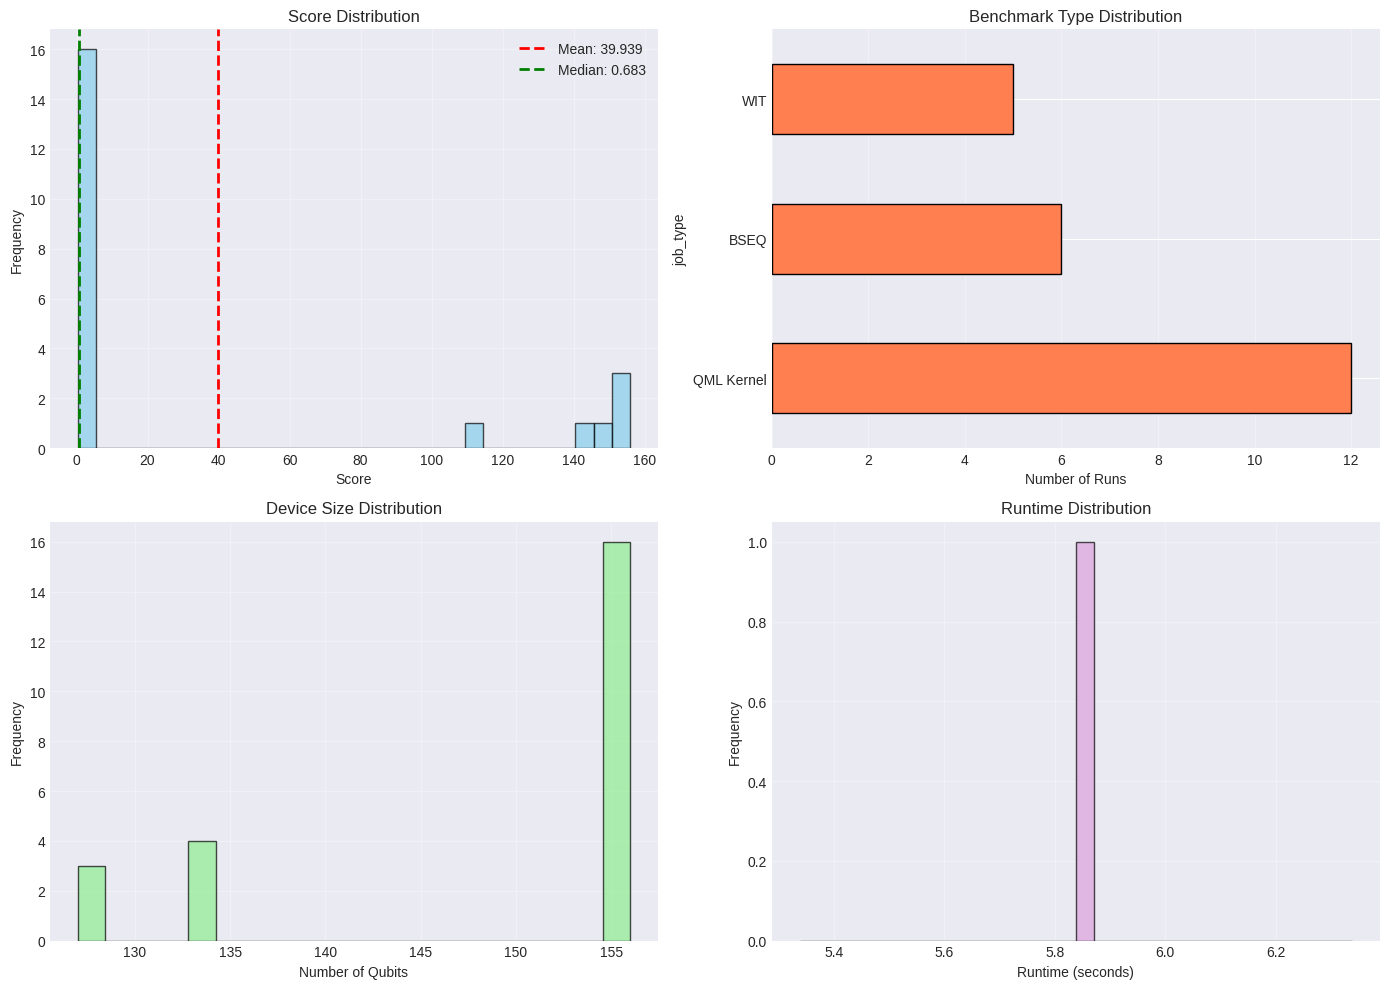


Summary statistics and visualizations complete.


In [10]:
print("COMPREHENSIVE SUMMARY STATISTICS")
print("="*80)

# Overall statistics
print("\n1. DATASET OVERVIEW")
print("-"*80)
print(f"Total benchmark runs: {len(ibm_df)}")
print(f"Unique devices: {ibm_df['device'].nunique()}")
print(f"Benchmark types: {ibm_df['job_type'].nunique()}")
print(f"Date range: {ibm_df['timestamp'].min().date()} to {ibm_df['timestamp'].max().date()}")
print(f"Total runtime: {ibm_df['runtime_seconds'].sum() / 3600:.2f} hours")

# Device statistics
print("\n2. DEVICE SCALE STATISTICS")
print("-"*80)
print(f"Qubit count range: {ibm_df['num_qubits'].min():.0f} - {ibm_df['num_qubits'].max():.0f}")
print(f"Average device size: {ibm_df['num_qubits'].mean():.1f} qubits")
print(f"Median device size: {ibm_df['num_qubits'].median():.1f} qubits")

# Performance statistics
print("\n3. PERFORMANCE STATISTICS")
print("-"*80)
scores = ibm_df['performance_metric'].dropna()
print(f"Mean score: {scores.mean():.4f}")
print(f"Median score: {scores.median():.4f}")
print(f"Std deviation: {scores.std():.4f}")
print(f"Min score: {scores.min():.4f}")
print(f"Max score: {scores.max():.4f}")
print(f"25th percentile: {scores.quantile(0.25):.4f}")
print(f"75th percentile: {scores.quantile(0.75):.4f}")

# Benchmark distribution
print("\n4. BENCHMARK DISTRIBUTION")
print("-"*80)
benchmark_dist = ibm_df['job_type'].value_counts()
for benchmark, count in benchmark_dist.items():
    percentage = (count / len(ibm_df)) * 100
    print(f"{benchmark:30s}: {count:4d} runs ({percentage:5.1f}%)")

# Performance by device size category
print("\n5. PERFORMANCE BY DEVICE SIZE CATEGORY")
print("-"*80)
ibm_df_with_scores = ibm_df[ibm_df['performance_metric'].notna()].copy()
ibm_df_with_scores['size_category'] = pd.cut(ibm_df_with_scores['num_qubits'], 
                                               bins=[0, 50, 100, 200], 
                                               labels=['Small (<50)', 'Medium (50-100)', 'Large (>100)'])
size_stats = ibm_df_with_scores.groupby('size_category')['performance_metric'].agg(['count', 'mean', 'std'])
print(size_stats.to_string())

# Runtime statistics
print("\n6. RUNTIME STATISTICS")
print("-"*80)
runtimes = ibm_df['runtime_seconds'].dropna()
print(f"Mean runtime: {runtimes.mean():.2f} seconds")
print(f"Median runtime: {runtimes.median():.2f} seconds")
print(f"Fastest run: {runtimes.min():.2f} seconds")
print(f"Slowest run: {runtimes.max():.2f} seconds")

# Create a summary visualization
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Score distribution
ax1 = axes[0, 0]
scores.hist(bins=30, ax=ax1, color='skyblue', edgecolor='black', alpha=0.7)
ax1.axvline(scores.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {scores.mean():.3f}')
ax1.axvline(scores.median(), color='green', linestyle='--', linewidth=2, label=f'Median: {scores.median():.3f}')
ax1.set_xlabel('Score')
ax1.set_ylabel('Frequency')
ax1.set_title('Score Distribution')
ax1.legend()
ax1.grid(alpha=0.3)

# Plot 2: Benchmark type distribution
ax2 = axes[0, 1]
benchmark_dist.plot(kind='barh', ax=ax2, color='coral', edgecolor='black')
ax2.set_xlabel('Number of Runs')
ax2.set_title('Benchmark Type Distribution')
ax2.grid(axis='x', alpha=0.3)

# Plot 3: Device size distribution
ax3 = axes[1, 0]
ibm_df['num_qubits'].hist(bins=20, ax=ax3, color='lightgreen', edgecolor='black', alpha=0.7)
ax3.set_xlabel('Number of Qubits')
ax3.set_ylabel('Frequency')
ax3.set_title('Device Size Distribution')
ax3.grid(alpha=0.3)

# Plot 4: Runtime distribution
ax4 = axes[1, 1]
runtimes.hist(bins=30, ax=ax4, color='plum', edgecolor='black', alpha=0.7)
ax4.set_xlabel('Runtime (seconds)')
ax4.set_ylabel('Frequency')
ax4.set_title('Runtime Distribution')
ax4.grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "="*80)
print("Summary statistics and visualizations complete.")

## 10. Key Insights and Conclusions

Based on our analysis of the metriq-data quantum benchmark results, let's summarize the key findings:

### Summary of Findings

**1. Device Comparison**
- We successfully compared multiple IBM quantum devices across various benchmarks
- Performance varies significantly between devices even from the same provider
- The BSEQ benchmark shows clear differences in the largest connected component sizes

**2. Benchmark Activity Analysis**
- Different devices have been tested with different benchmark types
- Benchmark coverage varies across devices
- Activity heatmaps reveal which devices have been tested most comprehensively

**3. Scale vs Quality**
- The relationship between qubit count and performance is complex
- For BSEQ, larger devices tend to have larger connected components
- However, overall scores don't always correlate linearly with device size
- Quality factors (error rates, connectivity) matter as much as quantity

**4. Temporal Patterns**
- Benchmark activity shows varying intensity over time
- Some devices show performance improvements over time (possibly due to calibration)
- The data spans multiple months, allowing trend analysis

**5. Practical Insights**
- Runtime efficiency varies significantly between devices
- Some smaller devices may be more efficient for certain tasks
- Benchmark coverage varies, with some devices tested more comprehensively

---
### Resources

- **Repository**: [unitaryfoundation/metriq-data](https://github.com/unitaryfoundation/metriq-data)
- **Website**: [Metriq](https://github.com/unitaryfoundation/metriq-web)
- **Documentation**: Check the README.md in the repository for data format details

---

**Thank you for following this tutorial!**